### Trying an end-to-end approach 

In [ ]:
# %pip install torch torchvision pillow tqdm

In [1]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import os
import json
from tqdm import tqdm
from random import sample

torch.cuda.empty_cache()

2.3.1


### Image transformations 

In [2]:
class ResizeAndPadTransform:
    def __init__(self, target_height=128, target_width=128):
        self.target_height = target_height
        self.target_width = target_width

    def __call__(self, img):
        w, h = img.size

        # Resize based on the larger dimension:
        if w >= h:
            if w > self.target_width:
                new_w = self.target_width
                new_h = int(round(h * self.target_width / w))
                img = transforms.Resize((new_h, new_w))(img)
        else:
            if h > self.target_height:
                new_h = self.target_height
                new_w = int(round(w * self.target_height / h))
                img = transforms.Resize((new_h, new_w))(img)

        # If it’s still larger than the target, resize it (which may slightly change the aspect ratio)
        w, h = img.size
        if w > self.target_width:
            # Resize width to target_width and scale height accordingly.
            new_w = self.target_width
            new_h = int(round(h * self.target_width / w))
            img = transforms.Resize((new_h, new_w))(img)
        if h > self.target_height:
            # Resize height to target_height and scale width accordingly.
            new_h = self.target_height
            new_w = int(round(w * self.target_height / h))
            img = transforms.Resize((new_h, new_w))(img)

        # After resizing, pad if any dimension is less than 128
        w, h = img.size
        pad_w = max(0, self.target_width - w)
        pad_h = max(0, self.target_height - h)
        left = pad_w // 2
        right = pad_w - left
        top = pad_h // 2
        bottom = pad_h - top
        img = transforms.functional.pad(img, (left, top, right, bottom), fill=0)

        # Convert to tensor and normalize
        img = transforms.ToTensor()(img)
        img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
        
        return img

In [3]:
frame_transform = transforms.Compose([
    ResizeAndPadTransform(target_height=128, target_width=128)
])

image_path = os.path.join("/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/train/images/0", "0_1.jpg")
image = Image.open(image_path).convert("RGB")
transformed_image = frame_transform(image)
print(transformed_image.shape)

torch.Size([3, 128, 128])


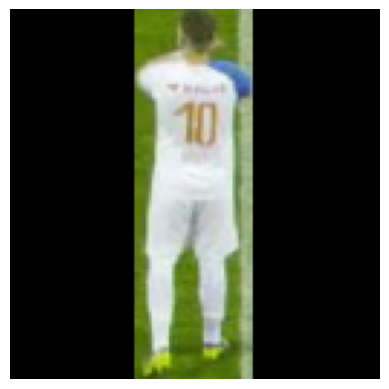

In [4]:
import matplotlib.pyplot as plt

# Convert the transformed tensor back to an image for visualization
transformed_image_np = transformed_image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
plt.imshow(transformed_image_np)
plt.axis('off')
plt.show()

### Define Dataset and Collate function for batching variable length sequences

In [5]:
class TrackletDataset(IterableDataset):
    def __init__(self, img_dir, gt_file, transform=None, tracklet_ids=None):
        super().__init__()
        self.img_dir = img_dir
        self.gt_file = gt_file
        self.transform = transform
        with open(gt_file, "r") as f:
            self.gt_data = json.load(f)
        if tracklet_ids == None:
            self.tracklet_ids = [d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))]
        else:
            self.tracklet_ids = tracklet_ids

    def __iter__(self):
        """
        Generator function for streaming the dataset.
        Yields: (tracklet_tensor, label)
        """
        for tracklet_id in tqdm(self.tracklet_ids, desc="Streaming tracklets"):
            tracklet_path = os.path.join(self.img_dir, tracklet_id)
            label = self.gt_data[tracklet_id]

            # Load images one by one
            images = []
            for filename in sorted(os.listdir(tracklet_path)):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(tracklet_path, filename)
                    try:
                        img = Image.open(img_path).convert("RGB")
                        if self.transform:
                            img = self.transform(img)
                        images.append(img)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        continue

            if len(images) == 0:
                continue

            tracklet_tensor = torch.stack(images)

            # Use 0 for the illegible class (CrossEntropyLoss requires labels starting at 0)
            label_tensor = torch.tensor(0 if label == -1 else label)

            yield tracklet_tensor, label_tensor

def collate_fn(batch):
    """
    Since some tracklets are longer than others, we need a custom collate function to divide them into batches.
    Our approach pads each sequence to the length of the longest sequence so it may be passed to nn.utils.rnn.pack_padded_sequence().
    Each element in the batch is a tuple (tracklet_tensor, label), where each tracklet_tensor has shape (max_seq_len, C, H, W).
    """
    tracklets, labels = zip(*batch)
    seq_lengths = [t.shape[0] for t in tracklets]

    # Sort the batch in descending order of sequence lengths
    sorted_indices = sorted(range(len(seq_lengths)), key=lambda i: seq_lengths[i], reverse=True)
    sorted_tracklets = [tracklets[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_seq_lengths = [seq_lengths[i] for i in sorted_indices]

    # Pad the tracklet sequences to the maximum sequence length in the batch
    padded_tracklets = pad_sequence(sorted_tracklets, batch_first=True)

    return padded_tracklets, torch.tensor(sorted_seq_lengths), torch.tensor(sorted_labels)

### Define the backbone architecture (taken from Laura's code)

In [6]:
class JerseyNumberClassifier(nn.Module):
    def __init__(self):
        super(JerseyNumberClassifier, self).__init__()
        
        # 128x128 input
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 64x64 input
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 32x32 input
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 16x16 input
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 8x8 input
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 4x4 input
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 2x2 output instead of 1x1
        self.fc = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 8192),  # Adjusted from 1024 * 1 * 1
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.fc(x)
        return x

In [7]:
cnn_model = torch.load("test_cnn.pth", weights_only=False)

# Checking whether .pth file contains model as well
if isinstance(cnn_model, dict):  # if only state_dict, then it means weights only
    print("Contains only weights.")
elif isinstance(cnn_model, nn.Module):  # entire model
    print("Contains the full cnn_model.")
else:
    print("Unknown format.")

Contains the full cnn_model.


In [7]:
class CNNFeatureExtractor(nn.Module):
    """Wrapper around the full model without the fc block."""
    def __init__(self, full_model):
        super(CNNFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            full_model.block1,
            full_model.block2,
            full_model.block3,
            full_model.block4,
            full_model.block5,
            full_model.block6       # Should be 1024 channels with 2x2 activation maps
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [8]:
class ImageRNN(nn.Module):
    def __init__(self, cnn_model, hidden_dim=512, num_layers=2, rnn_output_dim=100, rnn_type="LSTM", cnn_feature_dim=256):
        super(ImageRNN, self).__init__()
        # CNN feature extractor without the fc block
        self.cnn = CNNFeatureExtractor(cnn_model)
        # CNN output dimension is 1024 * 2 * 2 = 4096
        self.cnn_out_dim = 1024 * 2 * 2  
        # Projection layer: from 4096 to 256
        self.cnn_project = nn.Linear(self.cnn_out_dim, cnn_feature_dim)
        # RNN layer: input dimension is cnn_feature_dim
        rnn_cls = nn.LSTM if rnn_type == 'LSTM' else nn.GRU
        self.rnn = rnn_cls(input_size=cnn_feature_dim, hidden_size=hidden_dim, 
                           num_layers=num_layers, batch_first=True)
        # Final output layer
        self.fc = nn.Linear(hidden_dim, rnn_output_dim)

    def forward(self, x, seq_lengths):
        """
        x: Tensor of shape (batch_size, seq_len, C, H, W)
        seq_lengths: Tensor or list of actual sequence lengths for each tracklet.
        """
        batch_size, seq_len, C, H, W = x.shape
        cnn_features = []
#         print(seq_len)
        # Process each frame in the sequence
        for i in range(seq_len):
            img_batch = x[:, i]  # Shape: (batch_size, C, H, W)
            with torch.no_grad():  # Freeze CNN feature extractor if desired
                features = self.cnn(img_batch)  # Shape: (batch_size, 1024, 2, 2)
            features = features.view(batch_size, -1)  # Flatten to (batch_size, 4096)
            features = self.cnn_project(features)       # Project to (batch_size, cnn_feature_dim)
            cnn_features.append(features)
        # Stack along the time dimension: (batch_size, seq_len, cnn_feature_dim)
        cnn_features = torch.stack(cnn_features, dim=1)
        # Pack the padded sequence
        packed_seq = pack_padded_sequence(cnn_features, lengths=seq_lengths, batch_first=True, enforce_sorted=True)
        packed_out, _ = self.rnn(packed_seq)
        # Unpack the sequence
        padded_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # For each sample, select the output at the last valid time step
        last_outputs = []
        for i, length in enumerate(seq_lengths):
            last_outputs.append(padded_out[i, length - 1, :])
        last_outputs = torch.stack(last_outputs, dim=0)
        output = self.fc(last_outputs)  # Final prediction: (batch_size, rnn_output_dim)
        return output

In [9]:
IMG_DIR = r"/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/train/images/"
GT_FILE = r"/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/train/train_gt.json"

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [12]:
subset_fraction = 0.15

def create_subset(subset_fraction=0.15):
    tracklet_ids = [d for d in os.listdir(IMG_DIR) if os.path.isdir(os.path.join(IMG_DIR, d))]
    total_samples = len(tracklet_ids)
    num_samples = int(total_samples * subset_fraction)

    # Randomly sample the indices of tracklets to keep
    sampled_tracklet_ids = sample(tracklet_ids, num_samples)

    subset_dataset = TrackletDataset(IMG_DIR, GT_FILE, frame_transform, sampled_tracklet_ids)
    subset_dataloader = DataLoader(subset_dataset, batch_size=4, collate_fn=collate_fn)

    return subset_dataloader

# Create the subset dataloader (15% of the original dataset) to use for overfitting
subset_dataloader = create_subset(subset_fraction=subset_fraction)

In [15]:
cnn_model.eval() # freeze CNN weights 

# model = ImageRNN(cnn_model=cnn_model, hidden_dim=512, num_layers=2, cnn_feature_dim=512)
# model.to(DEVICE)

# criterion = nn.CrossEntropyLoss()  # or another appropriate loss
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
num_epochs = 30
losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    batch_count = 0  # Keep track of the number of batches in each epoch
    
    for batch_idx, (tracklets, seq_lengths_cpu, labels) in enumerate(subset_dataloader):
#         print(tracklets.shape, labels.shape)
        tracklets, labels = tracklets.to(DEVICE), labels.to(DEVICE)
        seq_lengths_gpu = seq_lengths_cpu.to(DEVICE)
    
        optimizer.zero_grad()
        outputs = model(tracklets, seq_lengths_cpu)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        
        print(f"Batch {batch_idx + 1}, Loss: {loss.item():.4f}")
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
        batch_count += 1

    epoch_loss = running_loss / batch_count
    losses.append(epoch_loss)
    accuracy = correct_predictions / total_predictions * 100
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

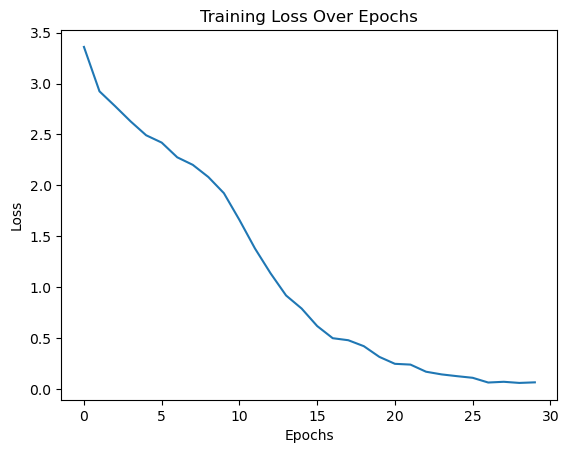

In [23]:
import matplotlib.pyplot as plt 

plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

In [30]:
print("Final loss after 30 epochs:", round(losses[-1],2))
print("Final training accuracy:", round(correct_predictions/total_predictions,2))

Final loss after 30 epochs: 0.06
Final training accuracy: 0.98


In [24]:
print(model)

ImageRNN(
  (cnn): CNNFeatureExtractor(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [25]:
torch.save(model, "rnn_overfit.pth")

### Evaluating after overfitting to small portion of dataset

In [10]:
# Need to first create a new Dataset and Dataloader that also return tracklet ID's

class TrackletTestDataset(IterableDataset):
    def __init__(self, img_dir, gt_file, transform=None, tracklet_ids=None):
        super().__init__()
        self.img_dir = img_dir
        self.gt_file = gt_file
        self.transform = transform
        with open(gt_file, "r") as f:
            self.gt_data = json.load(f)
        if tracklet_ids == None:
            self.tracklet_ids = [d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))]
        else:
            self.tracklet_ids = tracklet_ids

    def __iter__(self):
        """
        Generator function for streaming the dataset.
        Yields: (tracklet_tensor, label)
        """
        for tracklet_id in tqdm(self.tracklet_ids, desc="Streaming tracklets"):
            tracklet_path = os.path.join(self.img_dir, tracklet_id)
            label = self.gt_data[tracklet_id]

            # Load images one by one
            images = []
            for filename in sorted(os.listdir(tracklet_path)):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(tracklet_path, filename)
                    try:
                        img = Image.open(img_path).convert("RGB")
                        if self.transform:
                            img = self.transform(img)
                        images.append(img)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        continue

            if len(images) == 0:
                continue

            tracklet_tensor = torch.stack(images)

            # Use 0 for the illegible class (CrossEntropyLoss requires labels starting at 0)
            label_tensor = torch.tensor(0 if label == -1 else label)

            yield tracklet_tensor, label_tensor, str(tracklet_id)

def test_collate_fn(batch):
    """
    Since some tracklets are longer than others, we need a custom collate function to divide them into batches.
    Our approach pads each sequence to the length of the longest sequence so it may be passed to nn.utils.rnn.pack_padded_sequence().
    Each element in the batch is a tuple (tracklet_tensor, label), where each tracklet_tensor has shape (max_seq_len, C, H, W).
    """
    tracklets, labels, tracklet_ids = zip(*batch)
    seq_lengths = [t.shape[0] for t in tracklets]

    # Sort the batch in descending order of sequence lengths
    sorted_indices = sorted(range(len(seq_lengths)), key=lambda i: seq_lengths[i], reverse=True)
    sorted_tracklets = [tracklets[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_seq_lengths = [seq_lengths[i] for i in sorted_indices]
    sorted_tracklet_ids = [tracklet_ids[i] for i in sorted_indices]

    # Pad the tracklet sequences to the maximum sequence length in the batch
    padded_tracklets = pad_sequence(sorted_tracklets, batch_first=True)

    return padded_tracklets, torch.tensor(sorted_seq_lengths), torch.tensor(sorted_labels), sorted_tracklet_ids

In [11]:
IMG_DIR_TEST = r"/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/test/images/"
GT_FILE_TEST = r"/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/test/test_gt.json"

BATCH_SIZE = 4

test_dataset = TrackletTestDataset(IMG_DIR_TEST, GT_FILE_TEST, transform=frame_transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, collate_fn=test_collate_fn)

In [35]:
full_training_model = torch.load("rnn_overfit.pth")
print(full_training_model.state_dict().keys())

odict_keys(['cnn.features.0.0.weight', 'cnn.features.0.0.bias', 'cnn.features.0.2.weight', 'cnn.features.0.2.bias', 'cnn.features.1.0.weight', 'cnn.features.1.0.bias', 'cnn.features.1.2.weight', 'cnn.features.1.2.bias', 'cnn.features.2.0.weight', 'cnn.features.2.0.bias', 'cnn.features.2.2.weight', 'cnn.features.2.2.bias', 'cnn.features.3.0.weight', 'cnn.features.3.0.bias', 'cnn.features.3.2.weight', 'cnn.features.3.2.bias', 'cnn.features.4.0.weight', 'cnn.features.4.0.bias', 'cnn.features.4.2.weight', 'cnn.features.4.2.bias', 'cnn.features.5.0.weight', 'cnn.features.5.0.bias', 'cnn.features.5.2.weight', 'cnn.features.5.2.bias', 'cnn_project.weight', 'cnn_project.bias', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'fc.weight', 'fc.bias'])


In [37]:
full_training_model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
batch_count = 0

# Dictionary to store predictions in format expected by EvalAI: key = tracklet_id (string), value = predicted number (int)
predictions = {}

with torch.no_grad():
    for batch_idx, (tracklets, seq_lengths_cpu, labels, tracklet_ids) in enumerate(test_dataloader):
        tracklets, labels = tracklets.to(DEVICE), labels.to(DEVICE)
        seq_lengths = seq_lengths_cpu.to(DEVICE)
    
        outputs = full_training_model(tracklets, seq_lengths_cpu)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        batch_count += 1
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
        # Store each prediction, replacing 0 with -1
        for i, t_id in enumerate(tracklet_ids):
            pred_value = predicted[i].item()
            if pred_value == 0:
                pred_value = -1
            predictions[str(t_id)] = pred_value

average_loss = test_loss / batch_count
accuracy = (correct_predictions / total_predictions) * 100

print(f"Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
with open("overfit_test_preds.json", "w") as f:
    json.dump(predictions, f)

Streaming tracklets: 100%|██████████████████████████████████████████████████████████| 1211/1211 [35:27<00:00,  1.76s/it]


Test Loss: 5.6081, Test Accuracy: 19.98%


In [39]:
print(set(predictions.values()))

{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 36, 40, 44, 50, -1}


### Full training

In [13]:
# Creating a new class with the same layers but this time the CNN is also trainable.

class FinalImageRNN(nn.Module):
    
    # Init remains the same
    def __init__(self, cnn_model, hidden_dim=512, num_layers=2, rnn_output_dim=100, rnn_type="LSTM", cnn_feature_dim=256):
        super(FinalImageRNN, self).__init__()
        # CNN feature extractor without the fc block
        self.cnn = CNNFeatureExtractor(cnn_model)
        # CNN output dimension is 1024 * 2 * 2 = 4096
        self.cnn_out_dim = 1024 * 2 * 2  
        # Projection layer: from 4096 to 256
        self.cnn_project = nn.Linear(self.cnn_out_dim, cnn_feature_dim)
        # RNN layer: input dimension is cnn_feature_dim
        rnn_cls = nn.LSTM if rnn_type == 'LSTM' else nn.GRU
        self.rnn = rnn_cls(input_size=cnn_feature_dim, hidden_size=hidden_dim, 
                           num_layers=num_layers, batch_first=True)
        # Final output layer
        self.fc = nn.Linear(hidden_dim, rnn_output_dim)

    def forward(self, x, seq_lengths):
        """
        x: Tensor of shape (batch_size, seq_len, C, H, W)
        seq_lengths: Tensor or list of actual sequence lengths for each tracklet.
        """
        batch_size, seq_len, C, H, W = x.shape
        cnn_features = []
#         print(seq_len)
        # Process each frame in the sequence
        for i in range(seq_len):
            img_batch = x[:, i]  # Shape: (batch_size, C, H, W)
            
            # NO LONGER with torch.no_grad()
            features = self.cnn(img_batch)  # Shape: (batch_size, 1024, 2, 2)
            
            features = features.view(batch_size, -1)  # Flatten to (batch_size, 4096)
            features = self.cnn_project(features)       # Project to (batch_size, cnn_feature_dim)
            cnn_features.append(features)
        # Stack along the time dimension: (batch_size, seq_len, cnn_feature_dim)
        cnn_features = torch.stack(cnn_features, dim=1)
        # Pack the padded sequence
        packed_seq = pack_padded_sequence(cnn_features, lengths=seq_lengths, batch_first=True, enforce_sorted=True)
        packed_out, _ = self.rnn(packed_seq)
        # Unpack the sequence
        padded_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # For each sample, select the output at the last valid time step
        last_outputs = []
        for i, length in enumerate(seq_lengths):
            last_outputs.append(padded_out[i, length - 1, :])
        last_outputs = torch.stack(last_outputs, dim=0)
        output = self.fc(last_outputs)  # Final prediction: (batch_size, rnn_output_dim)
        return output

In [12]:
def evaluate_model(model, eval_dataloader, criterion, device, json_filename):
    """
    Encapsulates the code run a few cells ago, so that we can evaluate the model on the test set every couple of epochs.
    """
    model.eval()
    eval_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    batch_count = 0
    predictions = {}  # To store predictions for each tracklet

    with torch.no_grad():
        for batch_idx, (tracklets, seq_lengths_cpu, labels, tracklet_ids) in enumerate(eval_dataloader):
            tracklets, labels = tracklets.to(device), labels.to(device)
            seq_lengths = seq_lengths_cpu.to(device)
            
            outputs = model(tracklets, seq_lengths_cpu)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
            
            batch_count += 1
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            for i, t_id in enumerate(tracklet_ids):
                pred_value = predicted[i].item()
                if pred_value == 0:
                    pred_value = -1
                predictions[str(t_id)] = pred_value

    average_loss = eval_loss / batch_count
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Evaluation - Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    with open(json_filename, "w") as f:
        json.dump(predictions, f)
    
    return average_loss, accuracy

In [13]:
BATCH_SIZE = 6
CNN_LEARNING_RATE = 1e-5 # Lower LR for CNN, since we don't want the features to change faster than the RNN can learn 
RNN_LEARNING_RATE = 1e-4
FC_LEARNING_RATE = 1e-4 
EPOCHS = 6
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
dataset = TrackletDataset(os.path.join(IMG_DIR), os.path.join(GT_FILE), transform=frame_transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2, collate_fn=collate_fn)

In [19]:
torch.cuda.empty_cache()

In [20]:
trainable_cnn_model = torch.load("test_cnn.pth", weights_only=False)

In [21]:
overfit_state_dict = torch.load("rnn_overfit.pth", map_location=DEVICE).state_dict()

full_training_model = ImageRNN(cnn_model=trainable_cnn_model, hidden_dim=512, num_layers=2, cnn_feature_dim=512)
full_training_model.to(DEVICE)

# Load state dict from the previously trained (overfitted on 15% of dataset) RNN 
full_training_model.load_state_dict(overfit_state_dict, strict=True) 

criterion = nn.CrossEntropyLoss()  
full_training_optimizer = optim.Adam(full_training_model.parameters(), lr=LEARNING_RATE)

In [ ]:
# For per-epoch graph
full_training_losses = []
full_training_acc = []
# For per-batch graph
batch_losses = []
batch_accuracies = []

In [ ]:
log_file = "full_training_logs.txt"

# Write everything being printed to a text file to monitor performance.
with open(log_file, "a") as f:
    for epoch in range(1,EPOCHS):
        full_training_model.train()  # 
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        batch_count = 0  # Keeps track of the number of batches in each epoch

        for batch_idx, (tracklets, seq_lengths_cpu, labels) in enumerate(dataloader):
            tracklets, labels = tracklets.to(DEVICE), labels.to(DEVICE)
            seq_lengths_gpu = seq_lengths_cpu.to(DEVICE)

            full_training_optimizer.zero_grad()
            outputs = full_training_model(tracklets, seq_lengths_cpu)
            loss = criterion(outputs, labels)
            loss.backward()
            full_training_optimizer.step()

            # Batch statistics
            batch_loss = loss.item()
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).sum().item()
            batch_accuracy = (batch_correct / labels.size(0)) * 100
            batch_losses.append(batch_loss)
            batch_accuracies.append(batch_accuracy)

            # Track per-epoch stats
            running_loss += batch_loss
            correct_predictions += batch_correct
            total_predictions += labels.size(0)
            batch_count += 1

            # Print batch info every 10 batches
            if (batch_idx + 1) % 10 == 0:
                batch_log_msg = (
                    f"Epoch {epoch + 1}/{EPOCHS}, Batch {batch_idx + 1}, Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%"
                )
                print(batch_log_msg)
                f.write(batch_log_msg + "\n")

        epoch_loss = running_loss / batch_count
        accuracy = correct_predictions / total_predictions * 100

        full_training_losses.append(epoch_loss)
        full_training_acc.append(accuracy)

        epoch_log_msg = (
            f"\nEpoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%\n"
        )
        print(epoch_log_msg)
        f.write(epoch_log_msg)

        # Evaluate on test set every other epoch so we can keep track of learning. Also a good idea to save the weights
        if (epoch + 1) % 2 == 0:
            eval_json_filename = f"evaluation_epoch_{epoch+1}.json"
            avg_test_loss, test_accuracy = evaluate_model(full_training_model, test_dataloader, criterion, DEVICE, eval_json_filename)
            eval_log_msg = (
                f"Evaluation after epoch {epoch+1}: \nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%"
            )
            print(eval_log_msg)
            f.write(eval_log_msg + "\n")
            
            weights_filename = f"model_weights_epoch_{epoch+1}.pt"
            torch.save(full_training_model.state_dict(), weights_filename)
            save_log_msg = f"Saved model weights at: {weights_filename}\n"
            print(save_log_msg)
            f.write(save_log_msg)
            

In [ ]:
with open(log_file, "a") as f:
    for epoch in range(6,12):
        full_training_model.train()  # 
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        batch_count = 0  # Keeps track of the number of batches in each epoch

        for batch_idx, (tracklets, seq_lengths_cpu, labels) in enumerate(dataloader):
            tracklets, labels = tracklets.to(DEVICE), labels.to(DEVICE)
            seq_lengths_gpu = seq_lengths_cpu.to(DEVICE)

            full_training_optimizer.zero_grad()
            outputs = full_training_model(tracklets, seq_lengths_cpu)
            loss = criterion(outputs, labels)
            loss.backward()
            full_training_optimizer.step()

            # Batch statistics
            batch_loss = loss.item()
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).sum().item()
            batch_accuracy = (batch_correct / labels.size(0)) * 100
            batch_losses.append(batch_loss)
            batch_accuracies.append(batch_accuracy)

            # Track per-epoch stats
            running_loss += batch_loss
            correct_predictions += batch_correct
            total_predictions += labels.size(0)
            batch_count += 1

            # Print batch info every 10 batches
            if (batch_idx + 1) % 10 == 0:
                batch_log_msg = (
                    f"Epoch {epoch + 1}/{EPOCHS}, Batch {batch_idx + 1}, Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%"
                )
                print(batch_log_msg)
                f.write(batch_log_msg + "\n")

        epoch_loss = running_loss / batch_count
        accuracy = correct_predictions / total_predictions * 100

        full_training_losses.append(epoch_loss)
        full_training_acc.append(accuracy)

        epoch_log_msg = (
            f"\nEpoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%\n"
        )
        print(epoch_log_msg)
        f.write(epoch_log_msg)

        # Evaluate on test set every other epoch so we can keep track of learning. Also a good idea to save the weights
        if (epoch + 1) % 2 == 0:
            eval_json_filename = f"evaluation_epoch_{epoch+1}.json"
            avg_test_loss, test_accuracy = evaluate_model(full_training_model, test_dataloader, criterion, DEVICE, eval_json_filename)
            eval_log_msg = (
                f"Evaluation after epoch {epoch+1}: \nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%"
            )
            print(eval_log_msg)
            f.write(eval_log_msg + "\n")
            
            weights_filename = f"model_weights_epoch_{epoch+1}.pt"
            torch.save(full_training_model.state_dict(), weights_filename)
            save_log_msg = f"Saved model weights at: {weights_filename}\n"
            print(save_log_msg)
            f.write(save_log_msg)
            

In [ ]:
import matplotlib.pyplot as plt

plt.plot(full_training_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()